In [1]:
# The purpose of this notebook is to do data exploration on the EC.1* dataset
# as well as to split it into appropriate train/valid/test sets

In [2]:
from __future__ import annotations
import re
import numpy as np
import numpy.typing as npt
import pandas as pd
from pathlib import Path
from collections import defaultdict
from genslm_esm.dataset import read_fasta, write_fasta, Sequence

In [3]:
# Read the sequences
path = "/lambda_stor/homes/khippe/genslm_foundation/downstream_evaluation/ec_sequence_data/ec-1.ffn"
sequences = read_fasta(path)

In [4]:
# An example sequence header
sequences[0].tag

'f2313be0c0e306d5d67cb766b3f6de99\tPGF_00420358\tCytochrome c oxidase (cbb3-type) subunit CcoN (EC 1.9.3.1)'

In [5]:
ec_numbers = []
counter = defaultdict(int)
pattern = re.compile(r'\(EC\s([\d.-]+)\)')
for seq in sequences:
    match = pattern.search(seq.tag)
    ec_number = match.group(1) if match else ""
    counter[ec_number] += 1
    ec_numbers.append(ec_number)

print("Unique EC numbers", len(counter))
print("Total missing EC number:", counter[""])
print("Percent missing EC number:", round(counter[""] / len(sequences), 4) * 100)
counter.pop("")
sorted(counter.items(), key=lambda x: x[1])

Unique EC numbers 309
Total missing EC number: 0
Percent missing EC number: 0.0


[('1.1.-.-', 671),
 ('1.1.1.145', 990),
 ('1.14.19.2', 1190),
 ('1.3.98.-', 1295),
 ('1.14.14.1', 1805),
 ('1.5.1.36', 1821),
 ('1.18.1.3', 1925),
 ('1.14.13.221', 1979),
 ('1.14.13.70', 2232),
 ('1.1.1.159', 2479),
 ('1.3.1.87', 2560),
 ('1.13.11.25', 2597),
 ('1.12.98.4', 2670),
 ('1.1.1.53', 2726),
 ('1.5.1.21', 2773),
 ('1.4.3.4', 2969),
 ('1.1.1.215', 3539),
 ('1.3.99.-', 3553),
 ('1.11.1.1', 3857),
 ('1.8.99.2', 4004),
 ('1.14.14.12', 4023),
 ('1.1.1.298', 4051),
 ('1.1.1.333', 4133),
 ('1.14.12.19', 4247),
 ('1.1.3.21', 4434),
 ('1.8.1.-', 4659),
 ('1.3.98.1', 4831),
 ('1.1.1.154', 4921),
 ('1.1.1.29', 4999),
 ('1.1.1.56', 5137),
 ('1.14.13.59', 5194),
 ('1.14.13.142', 5229),
 ('1.14.13.24', 5274),
 ('1.2.1.9', 5326),
 ('1.3.1.28', 5647),
 ('1.1.1.11', 5664),
 ('1.2.3.3', 5677),
 ('1.1.98.3', 5719),
 ('1.1.1.130', 5731),
 ('1.13.11.16', 5824),
 ('1.7.2.1', 6489),
 ('1.14.13.141', 6536),
 ('1.1.1.43', 6934),
 ('1.1.1.274', 7033),
 ('1.13.11.15', 7064),
 ('1.7.99.6', 7142),
 ('1.1

array([[<Axes: title={'center': 'ec_number_occurences'}>]], dtype=object)

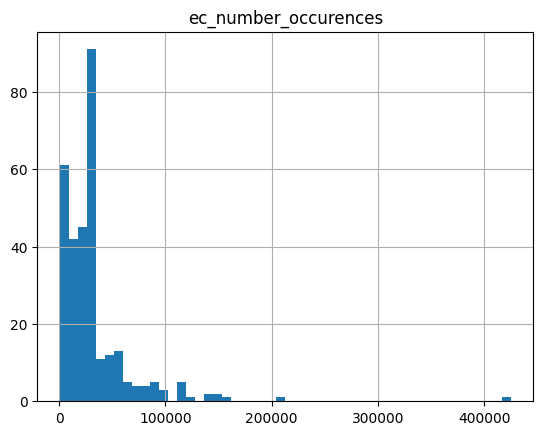

In [6]:
df = pd.DataFrame({"ec_number_occurences": counter.values()})
df.hist(bins=50)

In [7]:
df.describe()

,ec_number_occurences
count,309.000000
mean,32648.660194
std,37251.698672
min,671.000000
25%,12334.000000
50%,27715.000000
75%,30482.000000
max,425158.000000


array([[<Axes: title={'center': 'ec_number_frequency'}>]], dtype=object)

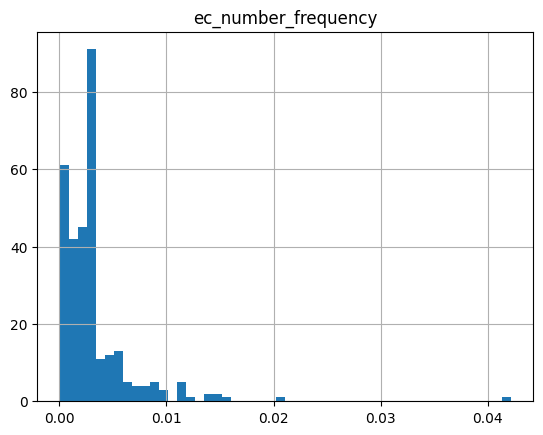

In [8]:
ec_frequencies = [count / sum(counter.values()) for count in counter.values()]
df = pd.DataFrame({"ec_number_frequency": ec_frequencies})
df.hist(bins=50)

In [9]:
df.describe()

,ec_number_frequency
count,309.000000
mean,0.003236
std,0.003693
min,0.000067
25%,0.001223
50%,0.002747
75%,0.003021
max,0.042143


In [10]:
# Get the most frequent ec number
ec, count = max(counter.items(), key=lambda x: x[1])
print(f"The most frequent EC number is {ec} \n Occurences: {count} \n Percentage: {count / sum(counter.values())}")

# This corresponds to EC 1.6.5.3 - NADH:ubiquinone reductase (H+-translocating)
# https://www.brenda-enzymes.info/enzyme.php?ecno=1.6.5.3

The most frequent EC number is 1.6.5.3 
 Occurences: 425158 
 Percentage: 0.04214310325207991


array([[<Axes: title={'center': 'Sequence Length'}>]], dtype=object)

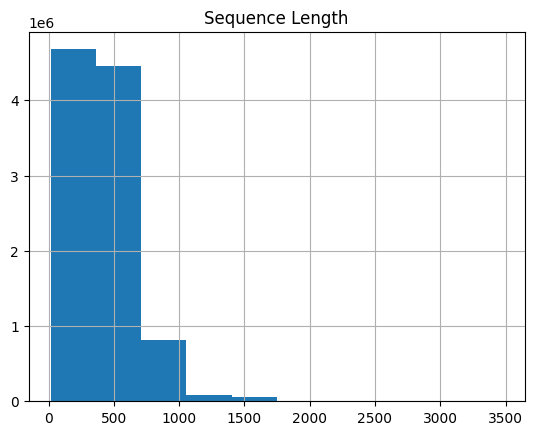

In [11]:
# Compute sequence length in 3-mers
seq_lens = [len(seq.sequence) // 3 for seq in sequences]
pd.DataFrame({"Sequence Length": seq_lens}).hist()

In [12]:
# Count the number of sequences with no start or stop codon
num_no_start_codon = sum(seq.sequence[:3] != "atg" for seq in sequences)
num_no_stop_codon = sum(seq.sequence[-3:] not in {"taa", "tag", "tga"} for seq in sequences)

print("Percent of sequences with no start codon:", round(num_no_start_codon / len(sequences), 4) * 100)
print("Percent of sequences with no stop codon:", round(num_no_stop_codon / len(sequences), 4) * 100)

Percent of sequences with no start codon: 13.54
Percent of sequences with no stop codon: 1.72


# Build a balanced training set

In [13]:
def stratified_sample(
    data: npt.ArrayLike,
    labels: npt.ArrayLike,
    proportions: tuple[float] = (0.8, 0.1, 0.1),
    seed: int = 42
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Group a dataset by it's labels and then split it into three random subsets.

    Parameters
    ----------
    data: npt.ArrayLike
        The data to be stratified.
    labels: npt.ArrayLike
        The labels to stratify based on.
    proportions: tuple[float, float, float]
        Tuple representing the proportions for the three subsets (should sum to 1)
    random_seed: int
        Seed for reproducibility.

    Returns:
    tuple[np.ndarray, np.ndarray, np.ndarray]
        Three subsets of (train, valid, test) indices as numpy arrays
    """

    # Check that the propotions sum to 1
    if sum(proportions) != 1.0:
        raise ValueError("Sum of proportions must be equal to 1.0")

    # Set the random seed
    np.random.seed(seed)
    
    # Group the indicies of each label into separate lists
    label_groups = defaultdict(list)
    for idx, label in enumerate(labels):
        label_groups[label].append(idx)

    # Convert to numpy for efficiency
    label_groups = {label: np.array(indices) for label, indices in label_groups.items()}

    # Determine the smallest label group
    size = len(min(label_groups.values(), key=lambda x: len(x)))

    # Decide train, valid, and test proportions
    train_size = int(proportions[0] * size)
    valid_size = int(proportions[1] * size)
    test_size = size - train_size - valid_size

    # Print summary statistics
    print(f"Total number of label groups:", len(label_groups))
    print(f"Smallest label group:", size)
    print(f"Splitting groups into (train={train_size}, valid={valid_size}, test={test_size}) examples")

    # Construct the train, valid, test sets by randomly sampling each group
    train, valid, test = [], [], []
    for label, indices in label_groups.items():
        # Take a random set of `size` items from each label group 
        split = np.random.choice(indices, size=size, replace=False)
        # Since the split is already random, simply extend the train, valid, test sets
        train.extend(split[:train_size])
        valid.extend(split[train_size:train_size + valid_size])
        test.extend(split[train_size + valid_size:])

    return train, valid, test

def subset_data(
    data: npt.ArrayLike,
    labels: npt.ArrayLike,
    inds: np.ndarray
) -> tuple[npt.ArrayLike, npt.ArrayLike]:
    """
    Subset the data and labels based on the indices.

    Parameters
    ----------
    data: npt.ArrayLike
        The dataset to subset.
    labels: npt.ArrayLike
        The labels to subset.
    inds: np.ndarray
        The indices of the subset.

    Returns
    -------
    tuple[npt.ArrayLike, npt.ArrayLike]
        The data and the label subsets
    """
    data_subset = [data[i] for i in inds]
    label_subset = [labels[i] for i in inds]
    return data_subset, label_subset

In [14]:
# Only take EC number labels if they are fully specified (no dashes)
labels = [ec for ec in ec_numbers if "-" not in ec]
data = [seq for seq, ec in zip(sequences, ec_numbers) if "-" not in ec]

# Prune out any of the sequence lengths greater than the maximum sequence length
# supported by ESM-2 models. 1024 - 2 (for start/end tokens)
labels = [label for seq, label in zip(data, labels) if len(seq.sequence) // 3 < 1022]
data = [seq for seq, ec in zip(data, ec_numbers) if len(seq.sequence) // 3 < 1022]

# Prune out any of the sequences that don't start with a start codon
labels = [label for seq, label in zip(data, labels) if seq.sequence[:3] == "atg"]
data = [seq for seq, ec in zip(data, ec_numbers) if seq.sequence[:3] == "atg"]

# Prune out any of the sequences that don't stop with a stop codon
labels = [label for seq, label in zip(data, labels) if seq.sequence[-3:] in {"taa", "tag", "tga"}]
data = [seq for seq, ec in zip(data, ec_numbers) if seq.sequence[-3:] in {"taa", "tag", "tga"}]

# Check sequence, labels are preserved
assert len(labels) == len(data)

# Run stratified sampling on the data to split the data into train, valid, test sets
# We first find the smallest label group, then we use that number to randomly sample 
# each EC label to ensure that each EC group is represented equally within the datasets.
train_inds, valid_inds, test_inds = stratified_sample(data, labels)

# Get the train, valid, test subsets
train_data, train_labels = subset_data(data, labels, train_inds)
valid_data, valid_labels = subset_data(data, labels, valid_inds)
test_data, test_labels = subset_data(data, labels, test_inds)

# Make sure none of the labels are repeated in train, valid, test sets
assert not set(train_inds).intersection(valid_inds)
assert not set(train_inds).intersection(test_inds)
assert not set(valid_inds).intersection(test_inds)

# Show the statistics
print("Training examples:", len(train_inds))
print("Validation examples:", len(valid_inds))
print("Testing examples:", len(test_inds))

Total number of label groups: 294
Smallest label group: 115
Splitting groups into (train=92, valid=11, test=12) examples
Training examples: 27048
Validation examples: 3234
Testing examples: 3528


In [15]:
# Write the datasets to disk

def write_data(data: list[Sequence], labels: npt.ArrayLike, output_dir: str, name: str) -> None:
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    write_fasta(data, output_dir / f"{name}.fasta")
    np.save(output_dir / f"{name}_labels.npy", labels)

write_data(train_data, train_labels, "ec_data_v1", "ec_v1_train")
write_data(valid_data, valid_labels, "ec_data_v1", "ec_v1_valid")
write_data(test_data, test_labels, "ec_data_v1", "ec_v1_test")

# Check basic statistics

array([[<Axes: title={'center': 'Train Length'}>]], dtype=object)

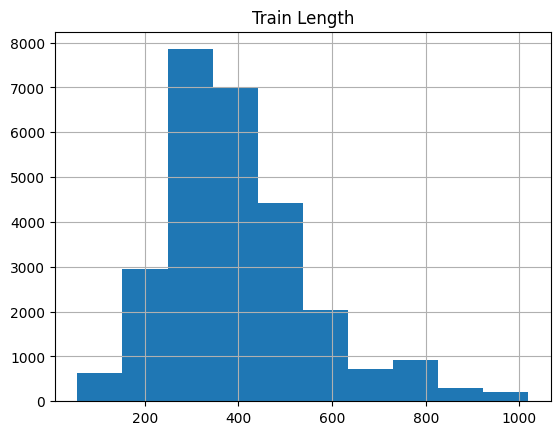

In [16]:
# Compute sequence length in 3-mers
train_lens = [len(seq.sequence) // 3 for seq in train_data]
valid_lens = [len(seq.sequence) // 3 for seq in valid_data]
test_lens = [len(seq.sequence) // 3 for seq in test_data]

pd.DataFrame({"Train Length": train_lens}).hist()

array([[<Axes: title={'center': 'Valid Length'}>]], dtype=object)

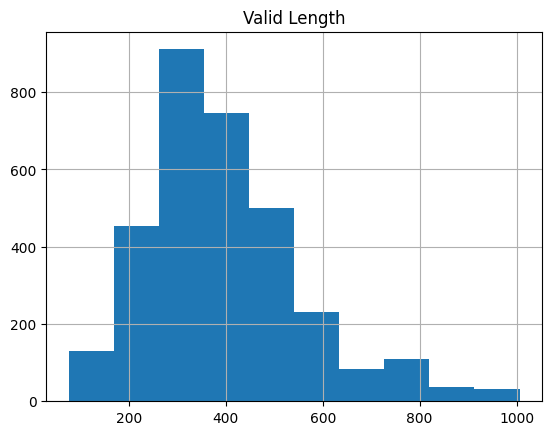

In [17]:
pd.DataFrame({"Valid Length": valid_lens}).hist()

array([[<Axes: title={'center': 'Test Length'}>]], dtype=object)

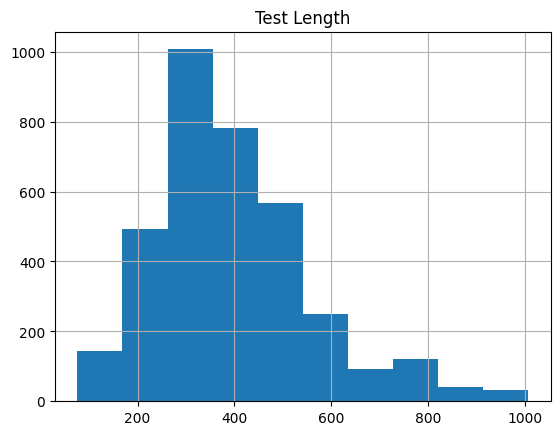

In [18]:
pd.DataFrame({"Test Length": test_lens}).hist()